# Electrodunas Modelo Supervisado Clasificación



In [38]:
#Importamos librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import table
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Cuenta ouliers
def contar_outliers(df):
    numero_de_outliers ={'Columnas':[], 'Numero Outliers':[]}
    for  column in range(df.shape[1]):
        lista_tipo=['float64', 'int64']
        if (df.iloc[:,column]).dtypes in lista_tipo:
            df_data=df.iloc[:,column]
            q1 = df_data.quantile(q=0.25)
            q2 = df_data.quantile(q=0.5)
            q3 = df_data.quantile(q=0.75)
            iqr = q3 - q1
            upper = q3 + 1.5 * iqr
            lower = q1 - 1.5 * iqr
            #Contar número de outliers
            ubicacion_outliers = (df_data<lower) | (df_data>upper)
            numero_outliers = ubicacion_outliers[ubicacion_outliers==True].sum()
            #print(numero_outliers)
            # Agrego suma de outliers por columna
            numero_de_outliers['Columnas'].append(df.columns[column])
            #numero_de_outliers['Columnas']=pd.concat([numero_de_outliers['Columnas'], df.columns[column]],ignore_index=True )
            numero_de_outliers['Numero Outliers'].append(numero_outliers)
            #numero_de_outliers['Numero Outliers']=pd.concat([numero_de_outliers['Numero Outliers'], numero_outliers],ignore_index=True )

    return pd.DataFrame(numero_de_outliers).sort_values('Numero Outliers', ascending=False)

In [3]:
#Leemos fuente de datos 
df = pd.read_csv("https://raw.githubusercontent.com/grupovajo/ProyectoMIAD/main/clustersModeloNoSupervisado.csv")

In [4]:
df.head()

,Unnamed: 0,Fecha,Active_energy,Reactive_energy,Voltaje_FA,Voltaje_FC,idCliente,Fecha2,Dia,Mes,Año,Hora,Minuto,Año_Mes,FactorPotencia,cluster
0,0,2021-01-01 00:00:00,0.357841,0.282788,455.139171,510.561002,1,2021-01-01,1,1,2021,0,0,2021-01,0.784582,0
1,1,2021-01-01 01:00:00,0.372264,0.431377,469.978787,469.917178,1,2021-01-01,1,1,2021,1,0,2021-01,0.653329,0
2,2,2021-01-01 02:00:00,1.044687,0.338626,468.721120,546.949147,1,2021-01-01,1,1,2021,2,0,2021-01,0.951274,0
3,3,2021-01-01 03:00:00,0.566425,0.495791,452.329255,444.122989,1,2021-01-01,1,1,2021,3,0,2021-01,0.752465,0
4,4,2021-01-01 04:00:00,1.080556,0.472018,513.477596,535.463719,1,2021-01-01,1,1,2021,4,0,2021-01,0.916383,0


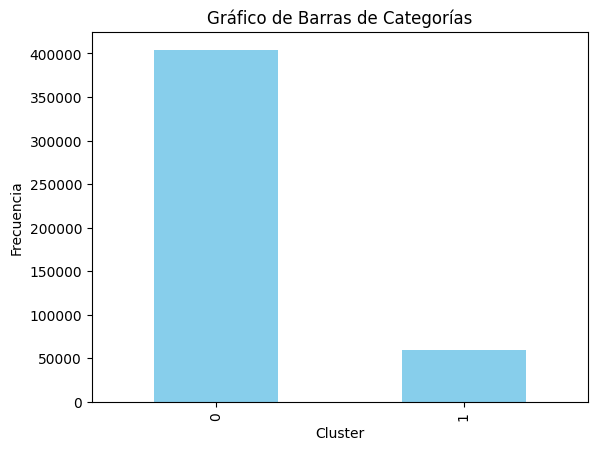

In [5]:
# Graficar el gráfico de barras cluster
df['cluster'].value_counts().plot(kind='bar', color='skyblue')
# Personalizar el gráfico
plt.title('Gráfico de Barras de Categorías')
plt.xlabel('Cluster')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()

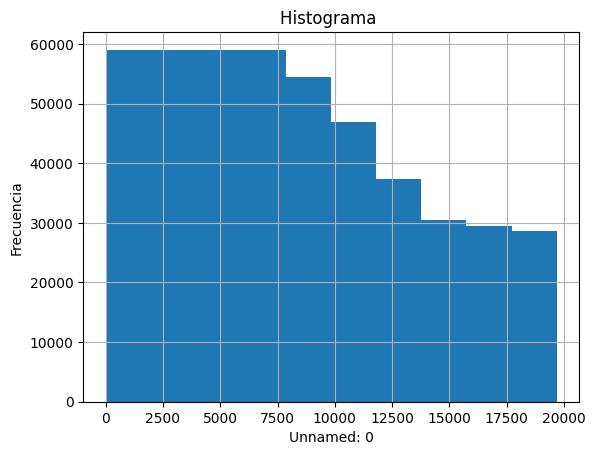

In [6]:
# Crear un histograma 
df['Unnamed: 0'].hist()

# Personalizar el gráfico
plt.title('Histograma ')
plt.xlabel('Unnamed: 0')
plt.ylabel('Frecuencia')

# Mostrar el histograma
plt.show()

In [7]:
# Convertir la columna de cadena a tipo de datos de tiempo
df['Fecha'] = pd.to_datetime(df['Fecha'])
df['Fecha2'] = pd.to_datetime(df['Fecha2'])
df['Año_Mes'] = pd.to_datetime(df['Año_Mes'])


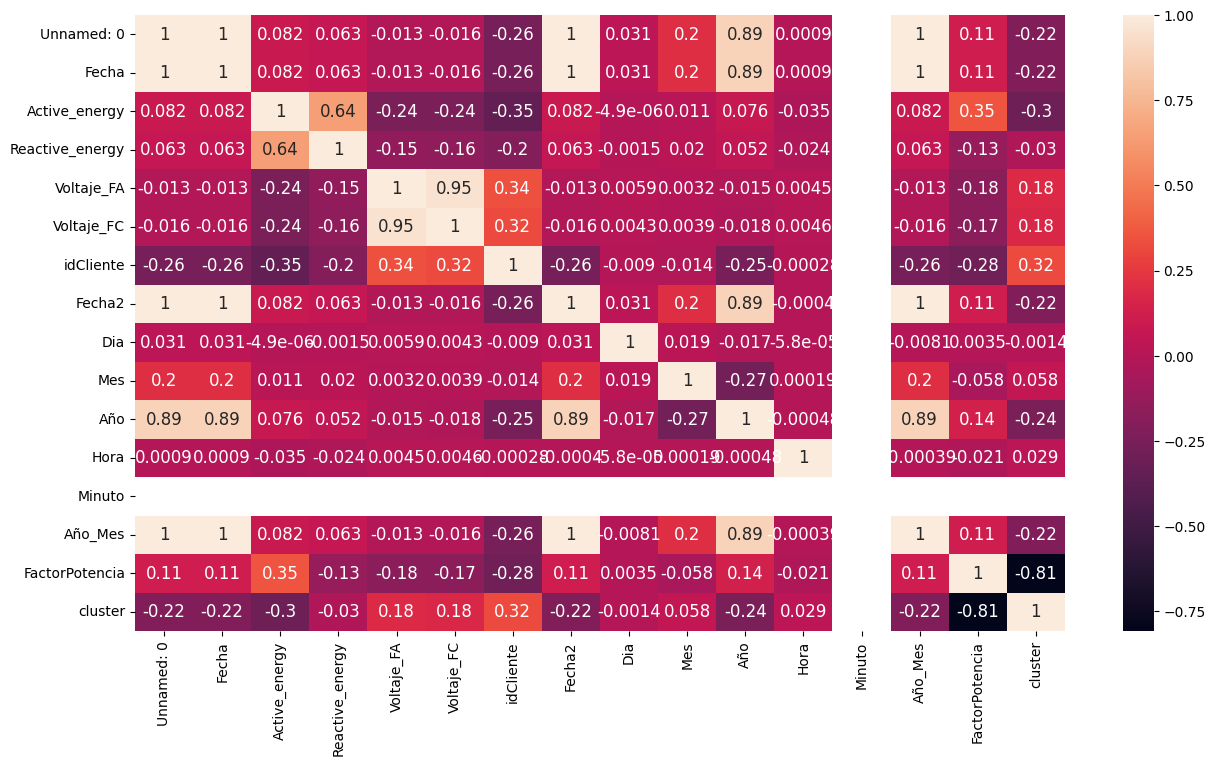

In [8]:
# Observamos que variables tienen mayor correlación al cluster
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr(), annot = True, annot_kws = {'size':12})
plt.show()

## Preparación de datos

Ahora, prepararemos los datos, definiendo la variable de respuesta y las variables predictoras.

In [9]:
#XTotal = df.loc[:,df.columns!='cluster']
XTotal = df.drop(columns=['cluster','FactorPotencia','Fecha2', 'Fecha', 'Año_Mes', 'Unnamed: 0','Voltaje_FC'])
yTotal = df.loc[:,df.columns=='cluster']

In [10]:
XTotal.columns

Index(['Active_energy', 'Reactive_energy', 'Voltaje_FA', 'idCliente', 'Dia',
       'Mes', 'Año', 'Hora', 'Minuto'],
      dtype='object')

Una vez definido las variables predictoras y de respuesta, normalizamos las primeras con el fin de que se encuentren en una misma escala.

In [11]:
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit(XTotal)
XTotalS=scaler.transform(XTotal)

Después de haber escalado las variables predictoras, dividimos el conjunto de datos en un set de entrenamiento y de prueba.

In [12]:
XTrain, XTest, yTrain, yTest = train_test_split(XTotalS, yTotal, test_size=0.30, random_state=3)

## Modelos de Clasificación

### Clasificación XGBoost

In [45]:
# Implementación y ajuste del modelo 
regXGB1 = XGBClassifier(learning_rate = 0.15, n_estimators=300, max_depth=10, min_child_weight=5, 
                       gamma=0.3, subsample=0.9, colsample_bytree=0.7, nthread=4, reg_alpha= 0.01, 
                       seed=27, n_jobs=-1).fit(XTrain, yTrain)

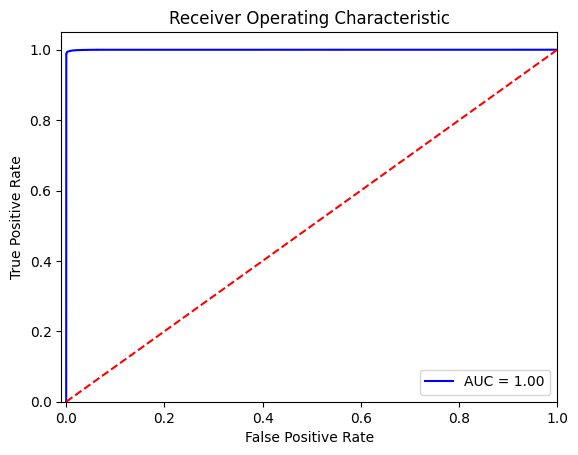

In [46]:
prediccionXGB1=regXGB1.predict_proba(XTest)[:,0]
fpr, tpr, thresholds = metrics.roc_curve(yTest, prediccionXGB1, pos_label=0)
AUCTree=metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUCTree)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [47]:
#A continuación, calculamos el error de clasificación, la matriz de confusión, el accuracy y la precisión.

#Realizamos la predicción con los datos de prueba.
predTree=regXGB1.predict(XTest)

#Obtenemos el error de la predicción.
'''errorTree=0
for i in range(0,len(yTest)):
    if(yTest.iloc[i]!=predTree[i]):
        errorTree+=1/len(yTest)     
print(f"El error de clasificación para el modelo árbol de decisión en la muestra de test es: {round(errorTree, 2)}")
'''
#Obtenemos la matriz de confusión.
print("Matriz de confusión:")
print(confusion_matrix(y_true=yTest, y_pred=predTree))

#Obtenemos el accuracy.
accTree=accuracy_score(y_true=yTest, y_pred=predTree)
print(f"El accuracy del modelo de clasificación XGB es: {round(accTree, 2)}")

#Obtenemos la precisión.
precTree=precision_score(y_true=yTest, y_pred=predTree)
print(f"La precisión del modelo de clasificación XGB es: {round(precTree, 2)}")

Matriz de confusión:
[[120884    241]
 [   266  17634]]
El accuracy del modelo de clasificación XGB es: 1.0
La precisión del modelo de clasificación XGB es: 0.99


### Red neuronal

In [29]:
import keras
from keras import backend as K
from keras import initializers
from keras import optimizers
from keras.optimizers import SGD
from keras import metrics
from keras.models import Sequential, Model
from keras.layers import LSTM
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import Input
from keras.layers import Embedding
#from keras.layers.recurrent import LSTM
#from keras.layers.core import Dense, Dropout
#from keras.layers import Input
#from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from keras.wrappers.scikit_learn import KerasClassifier
from livelossplot import PlotLossesKeras

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

In [30]:
output_var = yTrain.shape[1]
dims = XTrain.shape[1]

In [31]:
# Definición del modelo
NN3 = Sequential()
NN3.add(Dense(64, input_shape=(dims,),activation='relu'))
NN3.add(BatchNormalization())
NN3.add(Dropout(0.2))
NN3.add(Dense(128, activation='relu'))
NN3.add(BatchNormalization())
NN3.add(Dropout(0.2))
NN3.add(Dense(output_var, activation='sigmoid'))

In [32]:
print(NN3.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                640       
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 128)              

In [33]:
# Compilación del modelo
NN3.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=['AUC', 'accuracy']) #'accuracy'

# Entrenamiento del modelo
NN3.fit(XTrain, yTrain.to_numpy(), epochs=20, batch_size=64)

Epoch 1/20
5069/5069 [==============================] - 16s 3ms/step - loss: 0.1038 - auc: 0.9849 - accuracy: 0.9552
Epoch 2/20
5069/5069 [==============================] - 15s 3ms/step - loss: 0.0540 - auc: 0.9953 - accuracy: 0.9779
Epoch 3/20
5069/5069 [==============================] - 18s 3ms/step - loss: 0.0477 - auc: 0.9963 - accuracy: 0.9804
Epoch 4/20
5069/5069 [==============================] - 12s 2ms/step - loss: 0.0440 - auc: 0.9968 - accuracy: 0.9818
Epoch 5/20
5069/5069 [==============================] - 13s 2ms/step - loss: 0.0426 - auc: 0.9970 - accuracy: 0.9825
Epoch 6/20
5069/5069 [==============================] - 15s 3ms/step - loss: 0.0420 - auc: 0.9970 - accuracy: 0.9829
Epoch 7/20
5069/5069 [==============================] - 15s 3ms/step - loss: 0.0403 - auc: 0.9972 - accuracy: 0.9836
Epoch 8/20
5069/5069 [==============================] - 13s 3ms/step - loss: 0.0391 - auc: 0.9974 - accuracy: 0.9840
Epoch 9/20
5069/5069 [==============================] - 14s 3ms/

4345/4345 [==============================] - 4s 786us/step
El accuracy del modelo es: 0.9913828448120842
La precisión del modelo es: 0.9715947594307658
La matriz de confusión es: [[120622    503]
 [   695  17205]]
El AUC del modelo es: 0.9992016516480159


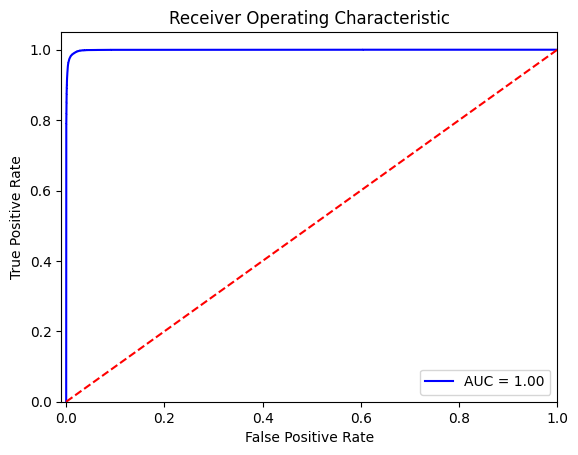

In [34]:
predicciones = NN3.predict(XTest)
y_pred = [round(x[0]) for x in predicciones]
print('El accuracy del modelo es: '+str(accuracy_score(y_true=yTest, y_pred=y_pred)))
print('La precisión del modelo es: '+str(precision_score(y_true=yTest, y_pred=y_pred)))
print('La matriz de confusión es: '+str(confusion_matrix(y_true=yTest, y_pred=y_pred)))
fpr, tpr, thresholds = metrics.roc_curve(yTest, predicciones, pos_label=1)
AUCRegLog=metrics.auc(fpr, tpr)
print('El AUC del modelo es: '+str(AUCRegLog))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUCRegLog)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Random Forest

In [39]:
# Defnición del modelo
clfRF1 = RandomForestClassifier(n_jobs=-1, n_estimators=100, max_depth=10, random_state=42)
# Entrenamiento del modelo
clfRF1.fit(XTrain, yTrain)

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=10, n_jobs=-1,
                                                     random_state=42))

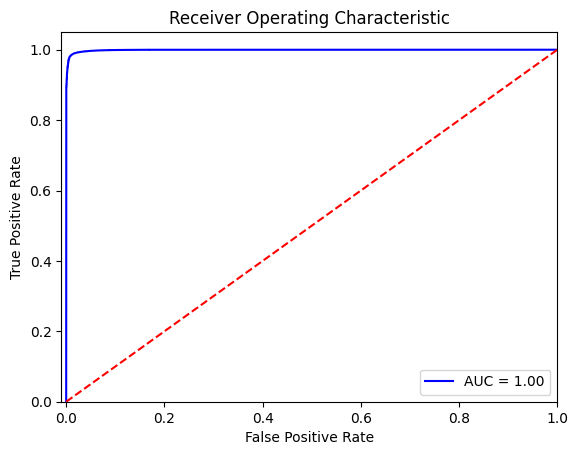

In [40]:
prediccionclfRF1=clfRF1.predict_proba(XTest)[:,0]
fpr, tpr, thresholds = metrics.roc_curve(yTest, prediccionclfRF1, pos_label=0)
AUCTree=metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUCTree)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [41]:
#A continuación, calculamos el error de clasificación, la matriz de confusión, el accuracy y la precisión.

#Realizamos la predicción con los datos de prueba.
predclfRF1=clfRF1.predict(XTest)


#Obtenemos la matriz de confusión.
print("Matriz de confusión:")
print(confusion_matrix(y_true=yTest, y_pred=predclfRF1))

#Obtenemos el accuracy.
accclfRF1=accuracy_score(y_true=yTest, y_pred=predclfRF1)
print(f"El accuracy del modelo de clasificación XGB es: {round(accclfRF1, 2)}")

#Obtenemos la precisión.
precclfRF1=precision_score(y_true=yTest, y_pred=predclfRF1)
print(f"La precisión del modelo de clasificación XGB es: {round(precclfRF1, 2)}")

Matriz de confusión:
[[120820    305]
 [  1055  16845]]
El accuracy del modelo de clasificación XGB es: 0.99
La precisión del modelo de clasificación XGB es: 0.98


### Gradient Boosting

In [42]:
# Defnición del modelo
clfGB= GradientBoostingClassifier(learning_rate=1.0,max_depth=10,random_state=0)
# Entrenamiento del modelo
clfGB.fit(XTrain, yTrain)

GradientBoostingClassifier(learning_rate=1.0, max_depth=10, random_state=0)

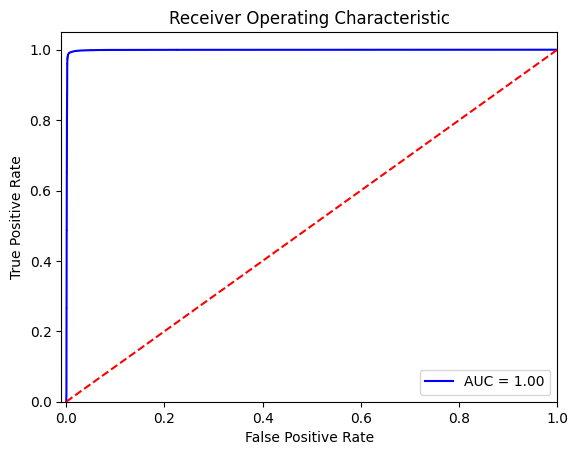

In [43]:
prediccionclfGB=clfGB.predict_proba(XTest)[:,0]
fpr, tpr, thresholds = metrics.roc_curve(yTest, prediccionclfGB, pos_label=0)
AUCclfGB=metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % AUCclfGB)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [44]:
#A continuación, calculamos el error de clasificación, la matriz de confusión, el accuracy y la precisión.

#Realizamos la predicción con los datos de prueba.
predclfGB=clfGB.predict(XTest)


#Obtenemos la matriz de confusión.
print("Matriz de confusión:")
print(confusion_matrix(y_true=yTest, y_pred=predclfGB))

#Obtenemos el accuracy.
acclfGB=accuracy_score(y_true=yTest, y_pred=predclfGB)
print(f"El accuracy del modelo de clasificación XGB es: {round(acclfGB, 2)}")

#Obtenemos la precisión.
precclfGB=precision_score(y_true=yTest, y_pred=predclfGB)
print(f"La precisión del modelo de clasificación XGB es: {round(precclfGB, 2)}")

Matriz de confusión:
[[120771    354]
 [   422  17478]]
El accuracy del modelo de clasificación XGB es: 0.99
La precisión del modelo de clasificación XGB es: 0.98
